# 5xFAD Resting State EEG


In [2]:
import os
import dill as pickle
import scienceplots
import numpy as np
import importlib

from PIL.ImageShow import IPythonViewer

import openephysextract

from openephysextract.utilities import savify
from openephysextract.utilities import loadify

from matplotlib import pyplot as plt

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210)
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)

source = '/Volumes/STORAGE 1.0/UNIC Research/5xFAD Resting State'
channels = [3, 4, 5, 6, 7, 8]
sampling_rate = 30000
output_1 = os.path.join(source, 'processed')
output_2 = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials/resting state analysis'

## I Preprocessing

### I.I Extraction

In [ ]:
importlib.reload(openephysextract.extractor)
from openephysextract.extractor import Extractor  

extractor = Extractor(
    source = source,
    channels = channels,
    sampling_rate = sampling_rate,
    output = output_1,
)

extracted = extractor.extractify(export = True)

In [ ]:
with open(os.path.join(output_1, 'raw_data.pkl'), 'rb') as f:
    extracted = pickle.load(f)

In [ ]:
import openephysextract.preprocess
importlib.reload(openephysextract.preprocess)
from openephysextract.trial import Trial
from openephysextract.preprocess import (
    Preprocessor,
    Trial,
    RemoveBadStep,
    FilterStep,
    DownsampleStep,
    EventCompileStep,
    EpochStep
)

# Step 2 — Define your preprocessing pipeline
steps = [
    RemoveBadStep(alpha=0.3, beta=0.7),
    DownsampleStep(target_fs=300),
    FilterStep(lowcut=0.1, highcut=80, order=4),
    EpochStep(frame=300, stride=30),
]

# Step 3 — Instantiate and run the processor
processor = Preprocessor(trials=extracted, steps=steps, destination=output_2)
processor.preprocess(parallel=False, export=True)

# Step 4 — Access your processed trials
processed = processor.processed

# Step 5 — (Optional) Use them
for trial in processed:
    print(trial)


In [ ]:
import openephysextract.utilities
importlib.reload(openephysextract.utilities)
from openephysextract.utilities import savify

test = processed[0]

test.data.shape, test.raw.shape

savify(test, output_2, 'test')

## II Analysis

In [ ]:
from openephysextract.utilities import loadify

processed = loadify(output_2, 'preprocessed_trials.pkl')

### II.I PSD Analysis

In [ ]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import bandpower

features = [bandpower(trial) for trial in processed]

savify(features, output_2, 'features')

In [ ]:
features = loadify(output_2, 'features')

### II.II Logistic Scaling (Garwood et. al)

In [ ]:
import openephysextract.analysis
importlib.reload(openephysextract.analysis)
from openephysextract.analysis import logistic_scaler as scaler

scaled = [scaler(trial) for trial in features]

savify(scaled, output_2, "logistic-scaled")

In [3]:
scaled = loadify(output_2, "logistic-scaled")

Loaded from /Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials/resting state analysis/logistic-scaled.pkl


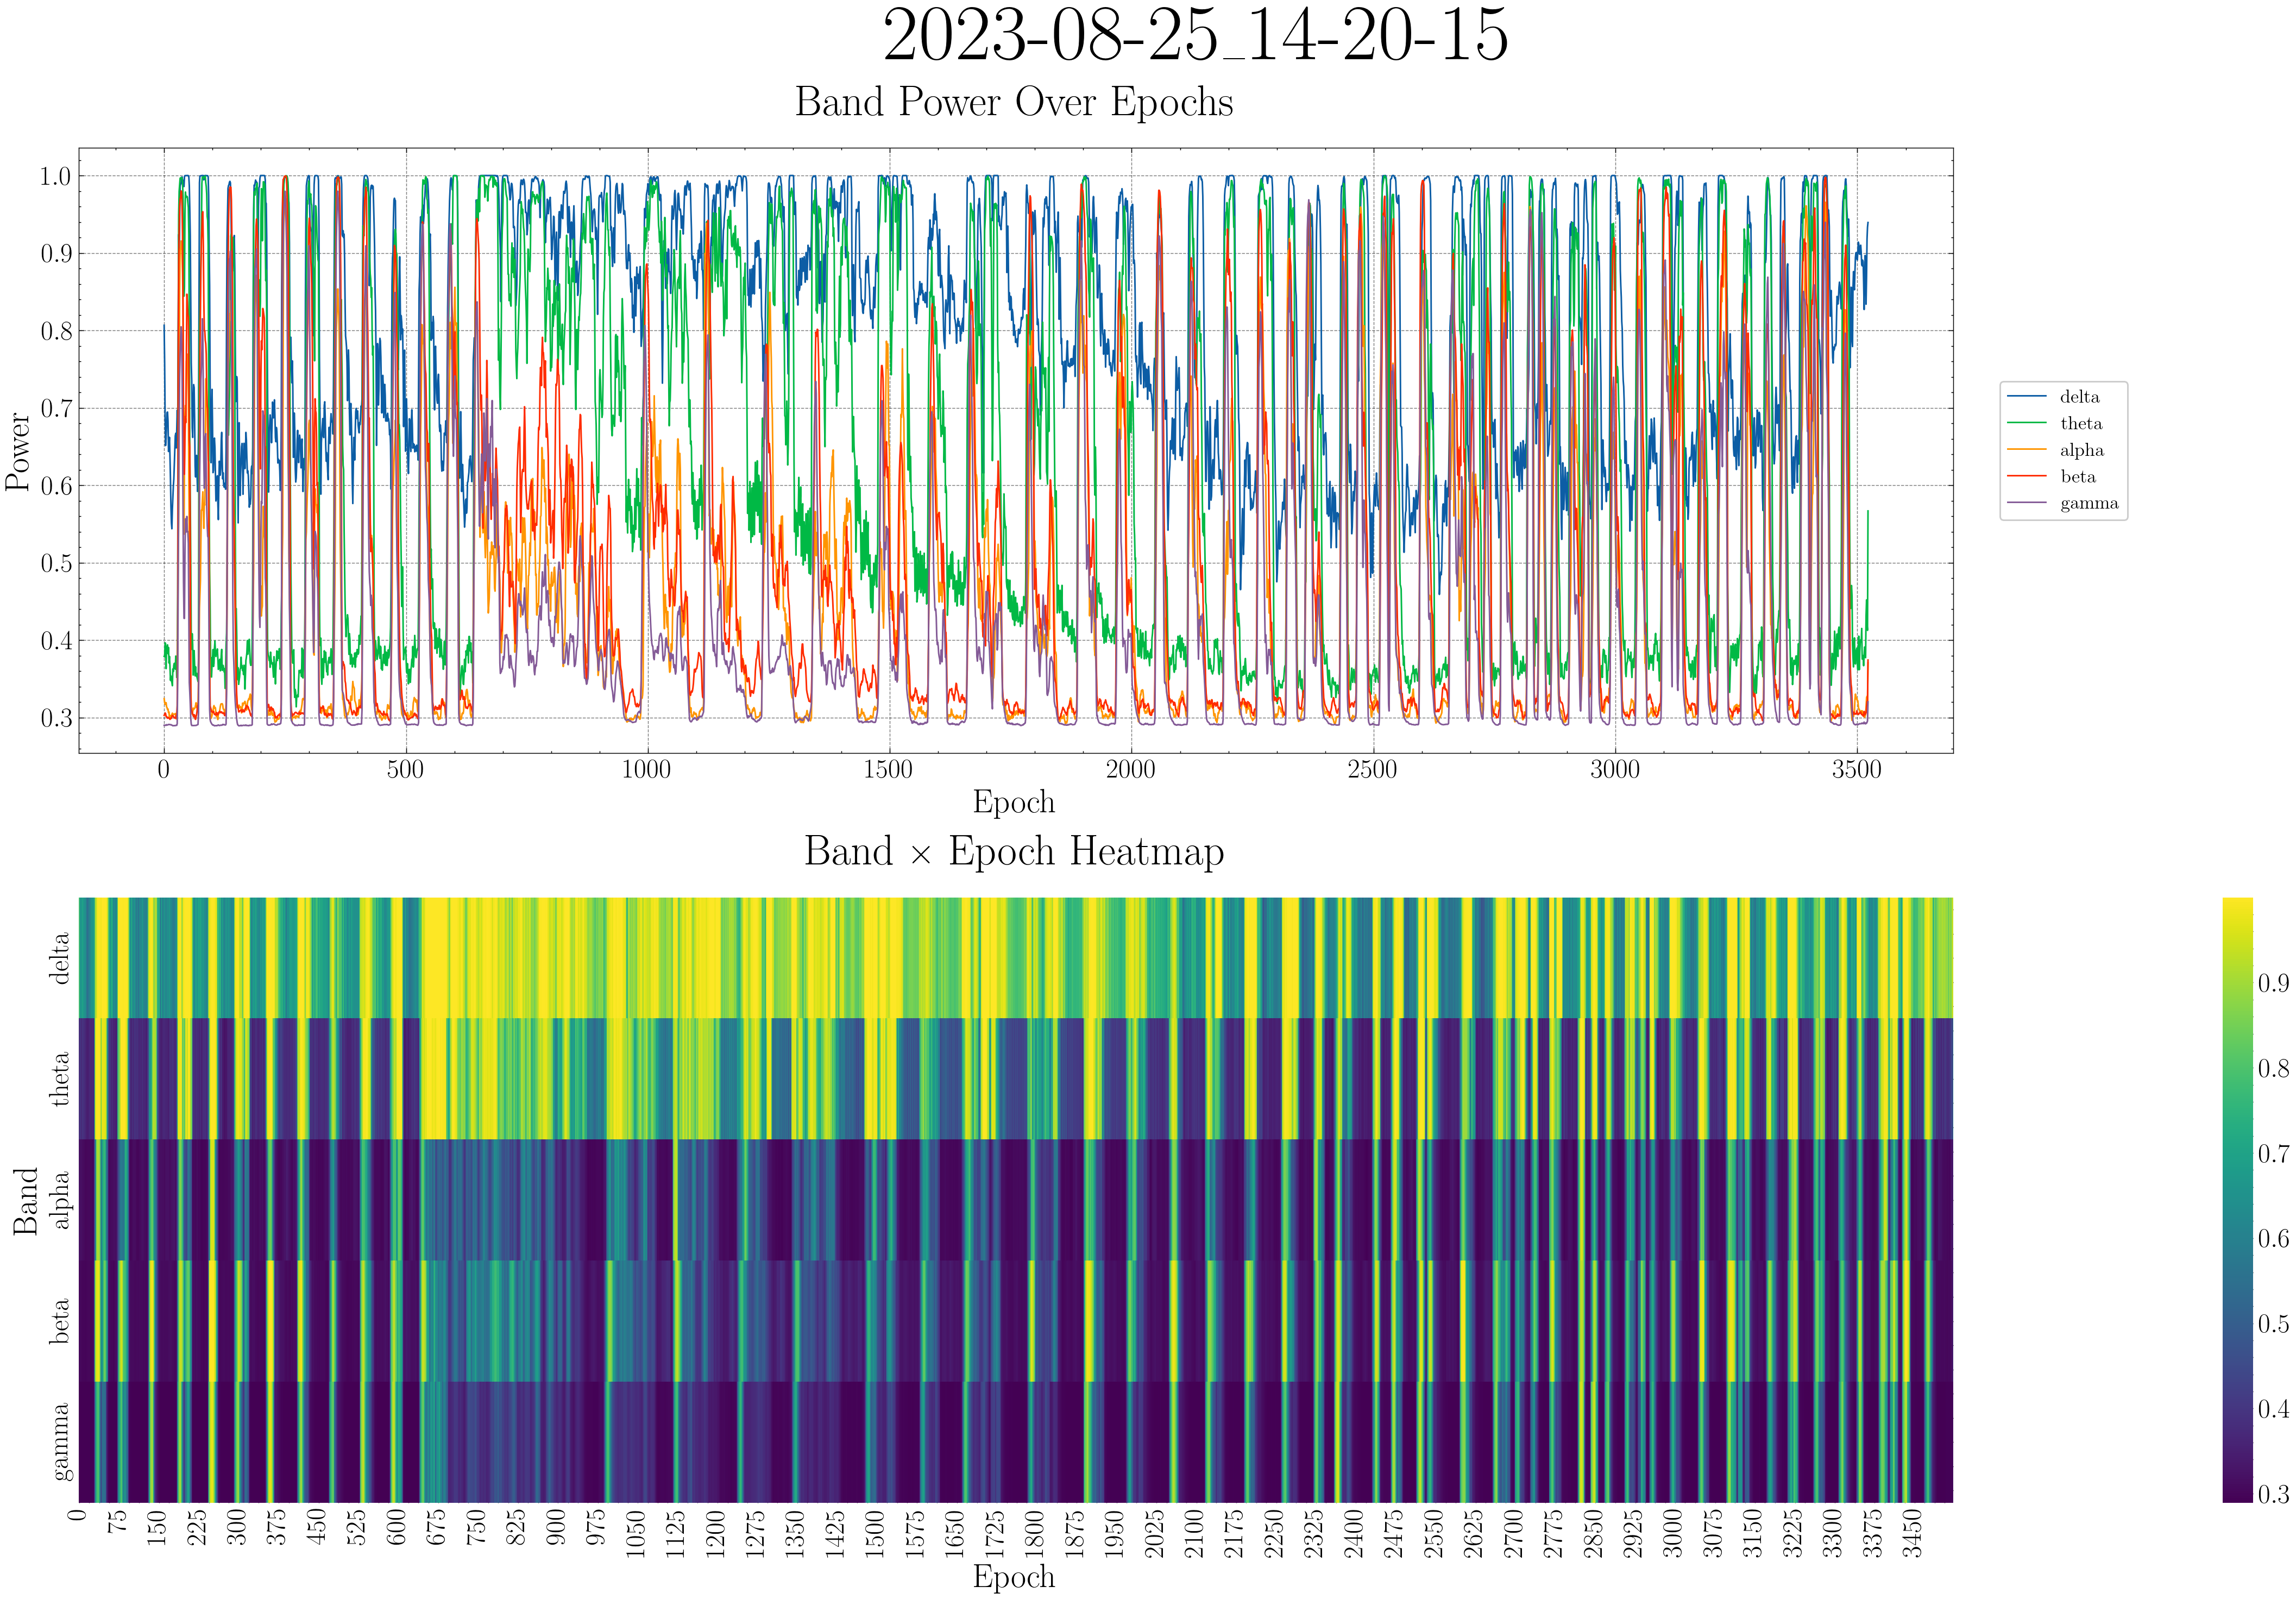

In [9]:
import openephysextract.plot
importlib.reload(openephysextract.plot)
from openephysextract.plot import plotifyEEGbands

plotifyEEGbands(scaled[0])

## III beta-HMM Construction

### III.I 

In [13]:
X = np.vstack([
    trial.data.reshape(trial.data.shape[0], -1)
    for trial in scaled
])

((3523, 4, 5), (53963, 20))

In [ ]:
from scipy.special import betaln, gammaln
from scipy.stats import beta

class betaHMM:
    
    def __init__(self, n_states, n_features, seed = None):

        self.K = n_states
        self.D = n_features
        self.rng = np.random.default_rng(seed)
        
        # dynamic selection of number of states
        self.dynamic = False
        self.Kmax = None
        self.criterion = None
        
        # initialisation
        self.pi = self.rng.dirichlet(alpha = np.ones(self.K))
        
        # transition matrix
        self.A = self.rng.dirichlet(alpha = np.ones(self.K), size = self.K)
        
        # beta parameters in [1.5, 3.0] to ensure uni-modal distributions
        self.alpha = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))
        self.beta = self.rng.uniform(1.5, 3.0, size=(self.K, self.D))

        self.log_likelihood = lambda y, k: np.sum(beta.logpdf(y, self.alpha[k], self.beta[k]))

    def compute_log_likelihood_matrix(self, Y):
        """
        """
        
        N = Y.shape[0]
        LL = np.zeros((N, self.K))
        
        for k in range(self.K):
            LL[:, k] = np.sum(beta.logpdf(Y, self.alpha[k], self.beta[k]))